In [16]:
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt
import PDEparams as pde

In [68]:
data = pd.read_csv('covid19_italy_region.csv')
data.head()

,SNo,Date,Country,RegionCode,RegionName,Latitude,Longitude,HospitalizedPatients,IntensiveCarePatients,TotalHospitalizedPatients,HomeConfinement,CurrentPositiveCases,NewPositiveCases,Recovered,Deaths,TotalPositiveCases,TestsPerformed
0,0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,NaN
1,1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,NaN
2,2,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,NaN
3,3,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,NaN
4,4,2020-02-24T18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,18,0,0,18,NaN


First of all we remove columns that are not useful for the analysis, and then we aggregate the remaining ones that represent number of cases, recovered and deceased individuals by date.

In [69]:
data['RecoveredOrDeceased'] = data['Recovered'] + data['Deaths']
cols = ['Country', 'RegionCode', 'Latitude', 'Longitude', 'TestsPerformed', 'RegionName',
       'HospitalizedPatients', 'IntensiveCarePatients', 'TotalHospitalizedPatients', 'HomeConfinement',
       'CurrentPositiveCases','TotalPositiveCases', 'SNo', 'Recovered', 'Deaths']
data.drop(cols,  axis = 1, inplace = True)
data = data.groupby(data['Date']).sum()
data.head()

,NewPositiveCases,RecoveredOrDeceased
Date,,
2020-02-24T18:00:00,221,8
2020-02-25T18:00:00,93,11
2020-02-26T18:00:00,78,15
2020-02-27T18:00:00,250,62
2020-02-28T18:00:00,238,67


The latter column represent the <b>total</b> number of deaths and recovered individuals at time t, so we consider the difference between consecutive days as the daily change in this feature.

In [70]:
diffs = data.diff(axis=0)
diffs['RecoveredOrDeceased'][0] = 8 
data['RecoveredOrDeceased'] = diffs['RecoveredOrDeceased']

data.head()

,NewPositiveCases,RecoveredOrDeceased
Date,,
2020-02-24T18:00:00,221,8.0
2020-02-25T18:00:00,93,3.0
2020-02-26T18:00:00,78,4.0
2020-02-27T18:00:00,250,47.0
2020-02-28T18:00:00,238,5.0


In [71]:
#Substitute dates by days
data.reset_index(drop=True, inplace=True)
p = data.index.values
data.insert( 0, column = 'Days', value = p)
data.head()

,Days,NewPositiveCases,RecoveredOrDeceased
0,0,221,8.0
1,1,93,3.0
2,2,78,4.0
3,3,250,47.0
4,4,238,5.0


<AxesSubplot:xlabel='Days', ylabel='RecoveredOrDeceased'>

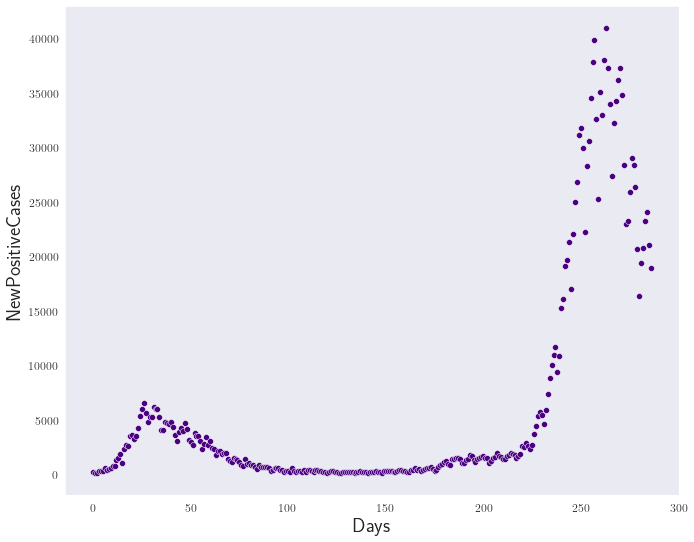

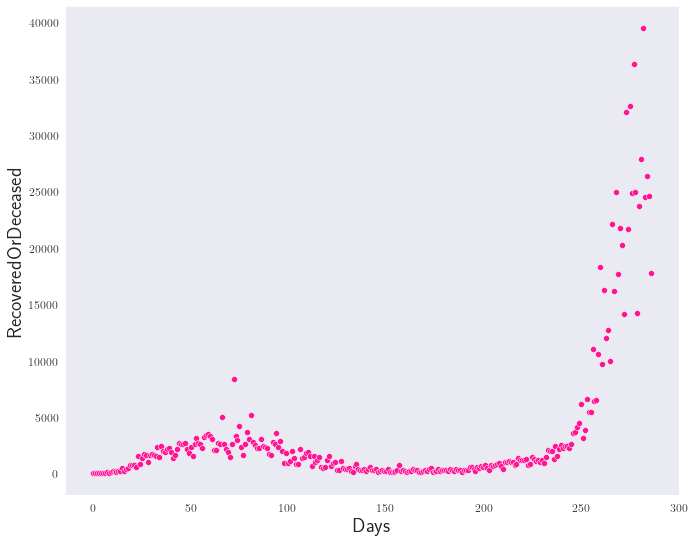

In [21]:
import seaborn as sns
sns.set_style("dark")
fig, ax = plt.subplots(figsize = (11, 9))
sns.scatterplot(data = data, x = 'Days', y = 'NewPositiveCases', color = 'indigo')

fig, ax = plt.subplots(figsize = (11, 9))
sns.scatterplot(data = data, x = 'Days', y = 'RecoveredOrDeceased', color = 'deeppink')

## SIR model

The basic SIR model assumes that the population is composed by three compartments at any given time $t$: susceptible
individuals (S), infectious individuals (I) and the number of recovered/deceased individuals (R).

<img src="https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png"  width="500" height="600"/>

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

where

$$\begin{align}
\beta &= \text{Contact Rate } \times \text{ Probability of Transmission}\\
\gamma &= \text{Recovery Rate} = \frac{1}{t_{\text{infectious}}}
\end{align}$$


In [22]:
#  Italian population as of end 2019 is equal to 60,359,546 people.
N = 60359546

def SIR(z, t, beta, gamma):
    S, I, R = z
    return [-(beta*S*I)/N, (beta*S*I)/N-gamma*I, gamma*I]

def initial_I():
    return 221 

def initial_R():
    return 8

def initial_S():
    return N-229 

In [23]:
%%time
from IPython.display import clear_output

# Loop with varying upper bounds
bounds_g = [1, 0.85, 0.65]
bounds_b = [1, 2.5, 5]
sz = len(bounds_g)
errors = np.zeros((sz,sz))

for i in range(sz):
    for j in range(sz):
        model = pde.PDEmodel(data, SIR, [initial_S, initial_I, initial_R], bounds=[(1e-3, bounds_b[i]), (1e-3, bounds_g[j])], 
                            param_names=[r'$beta$', r'$gamma$'], nvars = 3, ndims=0, nreplicates = 1, obsidx= [1,2], outfunc=None)
        model.fit()
        errors[i][j] = model.best_error
        clear_output()


Wall time: 26.4 s


In [24]:
ind = np.unravel_index(np.argmin(errors, axis=None), errors.shape)
print('Index of smallest error is:', ind)

Index of smallest error is: (0, 0)


In [25]:
SIR_model = pde.PDEmodel(data, SIR, [initial_S, initial_I, initial_R], bounds=[(1e-3, bounds_b[ind[0]]), (1e-3, bounds_g[ind[1]])], 
                        param_names=[r'$beta$', r'$gamma$'], nvars = 3, ndims=0, nreplicates = 1, obsidx= [1,2], outfunc=None)

In [26]:
SIR_model.fit()
SIR_model.best_params
print("Best error is: ", SIR_model.best_error)

     $beta$  $gamma$
0  0.027784  0.01019
Best error is:  23209213.274301156


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


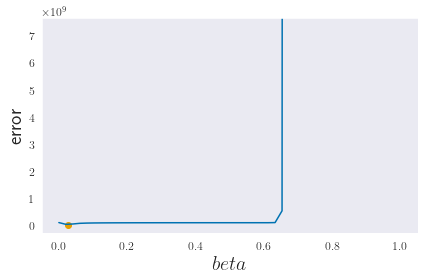

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


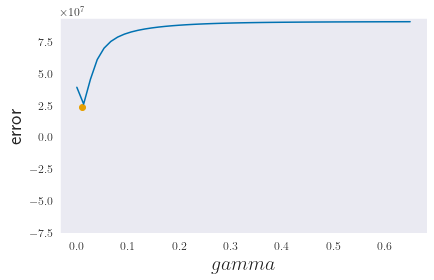

Wall time: 1min 58s


In [14]:
%%time
SIR_model.likelihood_profiles(npoints=50)
SIR_model.plot_profiles()

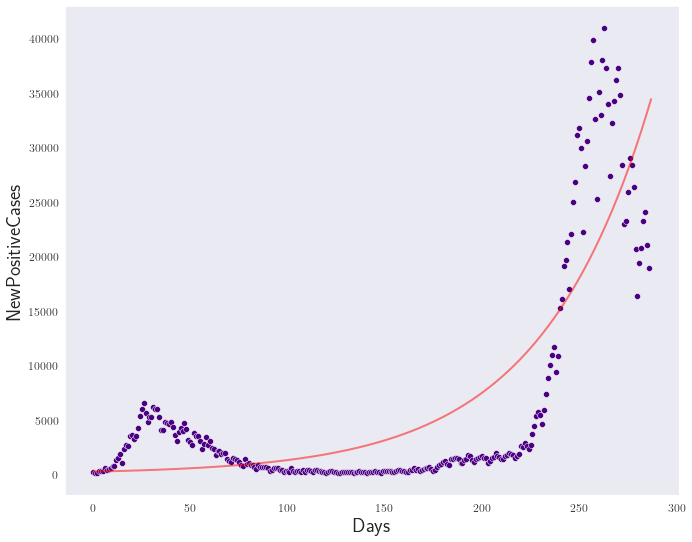

In [41]:
from scipy.integrate import odeint

#time grid
t = np.linspace(0, 287, 287)

def deriv_SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

y0 = N-229, 221, 8

ret = odeint(deriv_SIR, y0, t, args=(N, SIR_model.best_params.iat[0,0], SIR_model.best_params.iat[0,1]))
S, I, R = ret.T

fig, ax = plt.subplots(figsize = (11, 9))
sns.scatterplot(data = data, x = 'Days', y = 'NewPositiveCases', color = 'indigo')
ax.plot(t, I, 'r', alpha=0.5, lw=2)

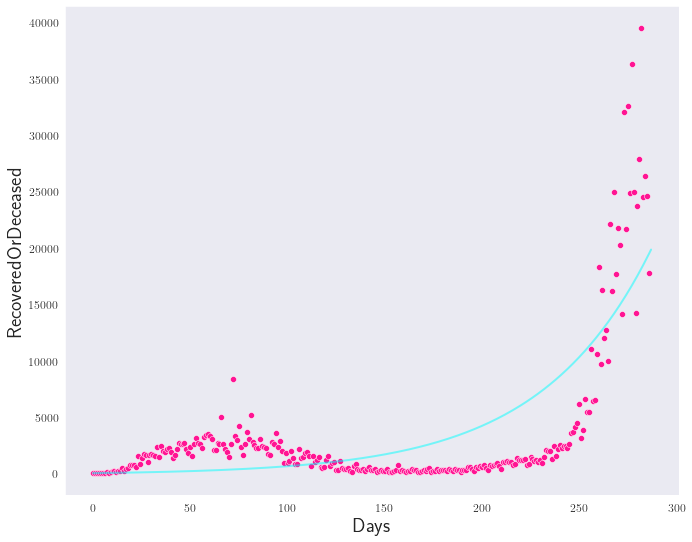

In [39]:
fig, ax = plt.subplots(figsize = (11, 9))
sns.scatterplot(data = data, x = 'Days', y = 'RecoveredOrDeceased', color = 'deeppink')
ax.plot(t, R, 'cyan', alpha=0.5, lw=2)

## SEIR model

This model is an extension to the SIR model: it takes into account the fact that there exists an incubation period (1-14 Days, most commonly 5 days (WHO)) in which the individual has been infected but not yet infectious. This is represented by the compartment (E) of exposed individuals.

<img src="https://idmod.org/docs/emod/airborne/_images/SEIR-SEIRS.png"  width="500" height="600"/>

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\frac{\beta\,S\,I}{N}\\
\frac{\mathrm{d} E}{\mathrm{d} t} &= \frac{\beta \,S\,I}{N} - \sigma\,E\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \sigma\,E-\gamma\,I \\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

where

$$\begin{align}
\beta &= \text{Infectious Rate }\\
\sigma &= \text{Incubation rate} &= \frac{1}{t_incubation}\\
\gamma &= \text{Recovery Rate}\\
\end{align}$$

i.e. $\beta$ controls the rate of spread which represents the probability of transmitting disease between a susceptible and an infectious individual and $\sigma$ is the rate of latent individuals becoming infectious. A closed population with no births or deaths is assumed. 

In [15]:
def SEIR(z, t, beta, gamma, sigma):
    S, E, I, R = z
    return [-(beta*S*I)/N, (beta*S*I)/N-sigma*E, sigma*E-gamma*I, gamma*I]

def initial_E():
    return 0

In [16]:
bounds_gs = [1, 0.85, 0.65]
bounds_b = [1, 2.5, 5]
sz = len(bounds_gs)
err = np.zeros((sz,sz))

for i in range(sz):
    for j in range(sz):
            model = pde.PDEmodel(data, SEIR, [initial_S, initial_E, initial_I, initial_R], bounds=[(1e-3, bounds_b[i]), (1e-3, bounds_gs[j]), (1e-3, bounds_gs[j])], 
                    param_names=[r'$beta$', r'$gamma$', r'$sigma$'], nvars = 4, ndims=0, nreplicates = 1, obsidx= [2,3], outfunc=None)
            model.fit()
            err[i,j] = model.best_error
            clear_output()

ind = np.unravel_index(np.argmin(err, axis=None), err.shape)
print('Index of smallest error is:', ind)   

Index of smallest error is: (2, 1)


In [17]:
SEIR_model = pde.PDEmodel(data, SEIR, [initial_S, initial_E, initial_I, initial_R], bounds=[(1e-3, bounds_b[ind[0]]), (1e-3, bounds_gs[ind[1]]), (1e-3, bounds_gs[ind[1]])], 
                            param_names=[r'$beta$', r'$gamma$', r'$sigma$'], nvars = 4, ndims=0, nreplicates = 1, obsidx= [2,3], outfunc=None)

SEIR_model.fit()
SEIR_model.best_params
print("Best error is: ", SEIR_model.best_error)

     $beta$   $gamma$   $sigma$
0  0.258257  0.012557  0.003114
Best error is:  21071011.531811204


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


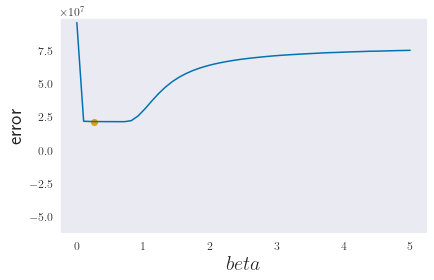

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


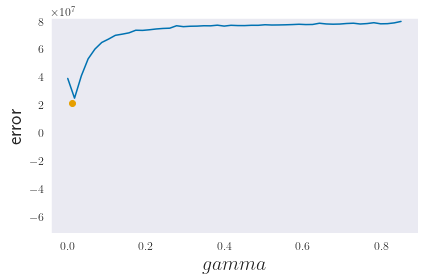

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


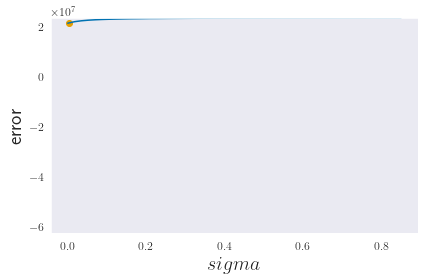

Wall time: 27min 12s


In [18]:
%%time
SEIR_model.likelihood_profiles(npoints=50)
SEIR_model.plot_profiles()

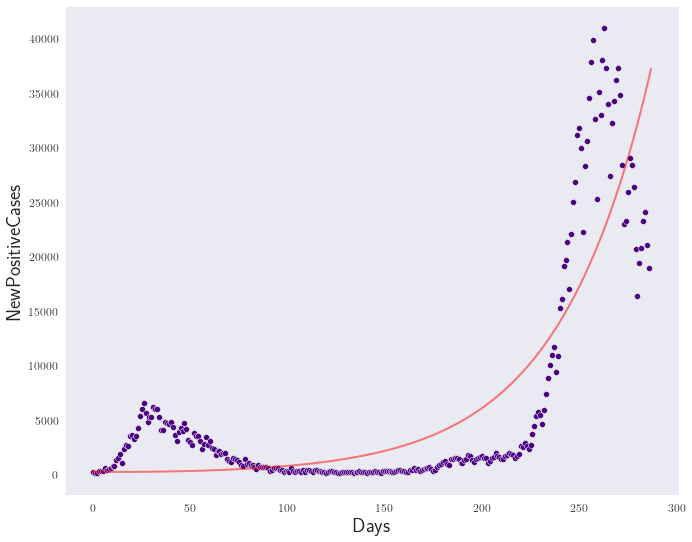

In [49]:
def deriv_SEIR(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt =(beta*S*I)/N-sigma*E
    dIdt = sigma*E-gamma*I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


y0 = N-229,0, 221, 8
ret = odeint(deriv_SEIR, y0, t, args=(N,  SIR_model.best_params.iat[0,0], SIR_model.best_params.iat[0,1],SIR_model.best_params.iat[0,2]))
S, E, I, R = ret.T

fig, ax = plt.subplots(figsize = (11, 9))
sns.scatterplot(data = data, x = 'Days', y = 'NewPositiveCases', color = 'indigo')
ax.plot(t, I, 'r', alpha=0.5, lw=2)

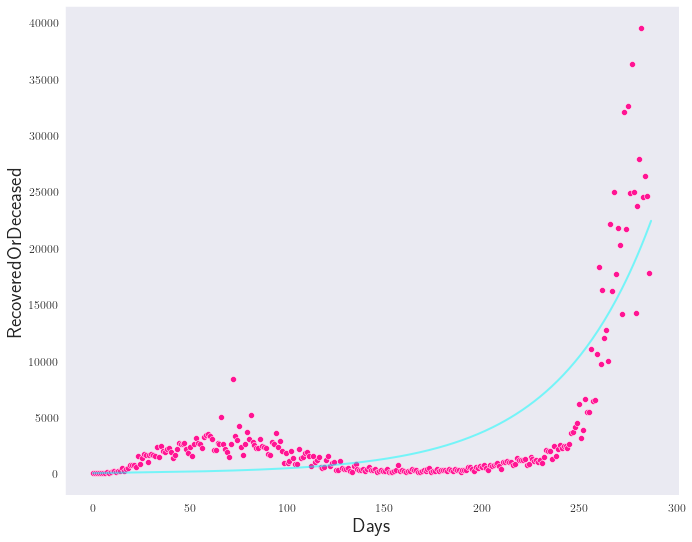

In [48]:
fig, ax = plt.subplots(figsize = (11, 9))
sns.scatterplot(data = data, x = 'Days', y = 'RecoveredOrDeceased', color = 'deeppink')
ax.plot(t, R, 'cyan', alpha=0.5, lw=2)

## Finally, lets fit again a SIR model but only with the first wave of contagions.

We will limit ourselves to the first 28 days of the pandemic and repeat everything.

In [72]:
data.drop(data.tail(287-29).index,inplace=True) 

<AxesSubplot:xlabel='Days', ylabel='RecoveredOrDeceased'>

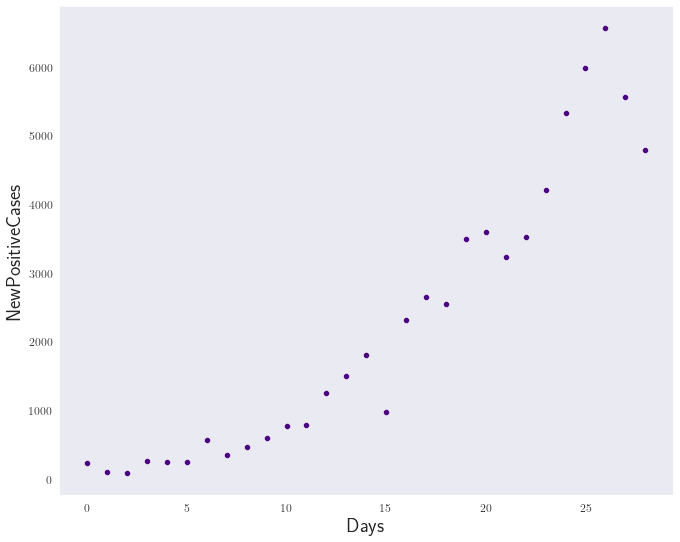

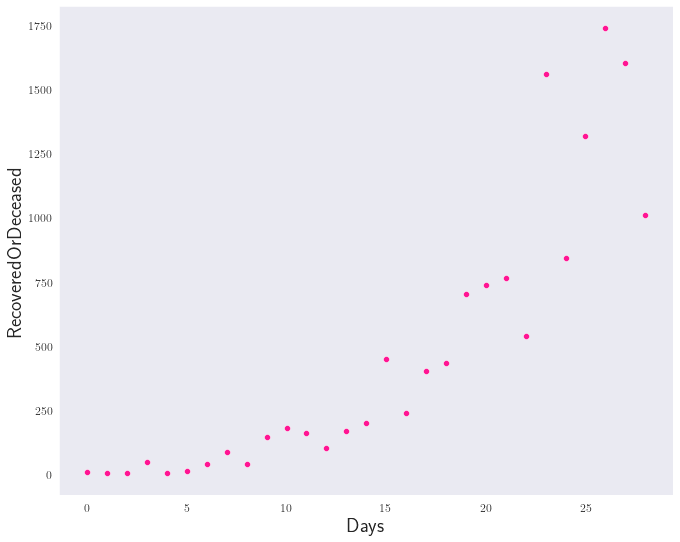

In [73]:
fig, ax = plt.subplots(figsize = (11, 9))
sns.scatterplot(data = data, x = 'Days', y = 'NewPositiveCases', color = 'indigo')

fig, ax = plt.subplots(figsize = (11, 9))
sns.scatterplot(data = data, x = 'Days', y = 'RecoveredOrDeceased', color = 'deeppink')

In [74]:
bounds_g = [1, 0.85, 0.65]
bounds_b = [1, 2.5, 5]
sz = len(bounds_g)
errors = np.zeros((sz,sz))

for i in range(sz):
    for j in range(sz):
        model = pde.PDEmodel(data, SIR, [initial_S, initial_I, initial_R], bounds=[(1e-3, bounds_b[i]), (1e-3, bounds_g[j])], 
                            param_names=[r'$beta$', r'$gamma$'], nvars = 3, ndims=0, nreplicates = 1, obsidx= [1,2], outfunc=None)
        model.fit()
        errors[i][j] = model.best_error
        clear_output()


In [75]:
ind = np.unravel_index(np.argmin(errors, axis=None), errors.shape)
SIR_model = pde.PDEmodel(data, SIR, [initial_S, initial_I, initial_R], bounds=[(1e-3, bounds_b[ind[0]]), (1e-3, bounds_g[ind[1]])], 
                        param_names=[r'$beta$', r'$gamma$'], nvars = 3, ndims=0, nreplicates = 1, obsidx= [1,2], outfunc=None)

In [76]:
SIR_model.fit()

     $beta$   $gamma$
0  0.154757  0.030621


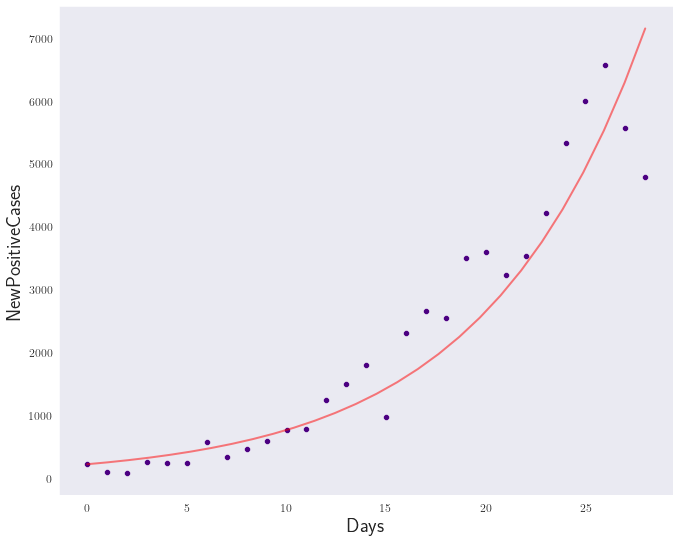

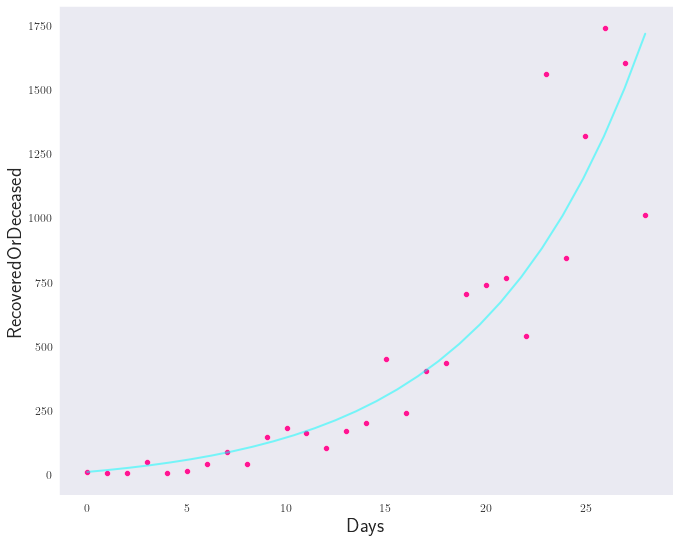

In [78]:
t = np.linspace(0, 28, 28)
y0 = N-229, 221, 8

ret = odeint(deriv_SIR, y0, t, args=(N, SIR_model.best_params.iat[0,0], SIR_model.best_params.iat[0,1]))
S, I, R = ret.T

fig, ax = plt.subplots(figsize = (11, 9))
sns.scatterplot(data = data, x = 'Days', y = 'NewPositiveCases', color = 'indigo')
ax.plot(t, I, 'r', alpha=0.5, lw=2)

fig, ax = plt.subplots(figsize = (11, 9))
sns.scatterplot(data = data, x = 'Days', y = 'RecoveredOrDeceased', color = 'deeppink')
ax.plot(t, R, 'cyan', alpha=0.5, lw=2)


We see that the model captures really well the behaviour on the first 24 days. 